This notebook explores very basics of a GP by implementing one from ground up using just Numpy and nothing else. This notebook very closely follows this blog post: http://krasserm.github.io/2018/03/19/gaussian-processes/

In [1]:
%matplotlib inline

import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

First a utility plotting function, to plot a GP with confidence intervals, traning data and drawn samples.

In [2]:
# utility function

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    # we assume X and mu are both lists of 1d points, so they have form [[a], [b], [c],...]
    # here we flatten them to 1d arrays, or just lists
    X = X.ravel()
    mu = mu.ravel()
    
    # diagonal of the covariance matrix is the variance at each point
    # square root of variance is standard deviation (how much it deviates at each point)
    # +/- 1.96 standard deviations from the mean covers roughly 95% of the area under a normal curve
    # so if we multiply stdev by 1.96 we get 95% confidence interval
    # which is to say that real value lies in this interval with 95% confidence/probability
    confidence_margin = 1.96 * np.sqrt(np.diag(cov))
    
    # plot confidence intervals at each point of X
    plt.fill_between(X, mu + confidence_margin, mu - confidence_margin, alpha=0.1)
    # plot mean
    plt.plot(X, mu, label='Mean')
    
    # if we've been given samples, plot them too
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    
    # if we've been given training data, plot that too
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')

    plt.legend()

Here we define an RBF kernel. Kernel is a function that, given two points, provides a measure of similarily between these two points. RBF in particular is known as stationary kernel, because it doesn't depend on X1 and X2, and only on their difference instead.

Complete formula for our RBF kernel:

$$
k(x_i, x_j) = \sigma^2 (-\frac{1}{2 l}(x_i - x_j)^T(x_i - x_j))
$$

RBF comes with two parameters: $l$ and $\sigma$. $l$ controls smoothness "horizontally", basically how much a function will wiggle on a given x-range. It is called lengthscale, and can be separate for each dimension of X, or the same. We are going with same $l$ for simplicity, so our RBF is called isotropic. $\sigma$ controls vertical spread. There are simple illustrations of effects these parameters have at the bottom of this notebook.

In [3]:
def rbf_kernel(X1, X2, l=1.0, sigma=1.0):
    """
    Isotropic squared exponential kernel.

    Complete formula:
        k(x_i, x_j) = sigma^2 * (- 1 / (2 * l) * (x_i - x_j)^T * (x_i - x_j))
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        l: Lengthscale, constrols the smoothness of the function.
           The kernel is called isotropic because we are using the same l for all dimensions.
        sigma: Controls the vertical variation.

    Returns:
        (m x n) matrix.
    """

    # The part that multiplies Xs can be simplified to the matrix form used in the implementation below
    # (with pen, paper and some experimenting with numpy).
    x1_x2_part = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2*np.dot(X1, X2.T)
    return sigma**2 * np.exp(-1.0/(2 * l**2) * x1_x2_part)


Here we show GP prior. We just need to set mean and covariance matrix. At the beginning we have no data, so our mean is zero. Since we don't have any data about the function, our covariance is just kernel output, which is simple: the closer the points are, and bigger is their covariance. RBF outputs 1 for identical points.

With zero mean and kernel function to calculate covariance, we have everything to setup our GP as a multivariate normal distribution. Now we can sample from this distribution, and this gives us some nice functions as samples.

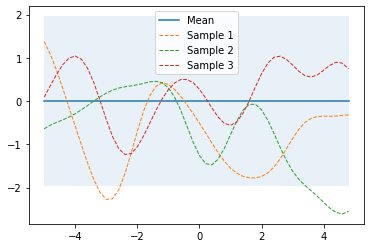

In [4]:
# first we just pick some 1d points
X = np.arange(-5, 5, .2).reshape(-1, 1)

# calculate mean and covariance
mean = np.zeros(X.shape)
covariance = rbf_kernel(X, X)

# mean and covariance matrix define a multivariate normal distribution
# we draw some samples from it
samples = np.random.multivariate_normal(mean.ravel(), covariance, 3)

plot_gp(mean, covariance, X, samples=samples)

Main part - training and deriving posterior. So we get some input-output pairs, and that allows us to calculate new mean and new covariance. There is a bunch of derivations going on there. Importantly we assume noisy observations, and thus add some noise to training points data.

The formulas are as follows.


$$ p(y_s | X_s, X_{train}, y_{train}) = N(y_s | \mu_s, \Sigma_s + \epsilon * I) $$

$$ \mu_s = K_s^T * K^{-1} * y_{train} $$

$$ \Sigma_s = K_{ss} - K_s^T  K^{-1}  K_s $$

here
* $X_{train}, y_{train}$ - training data, observations from the fuction we are modelling
* $X_{s}$ - points where we want to predict
* $K = kernel(X_{train}, X_{train}) + \epsilon * I$ - covariance between training points. Here we account for the noise in our observations with $\epsilon$ noise added to the diagonal
* $K_s = kernel(X_{train}, X_s)$ - covariance between training and new input points
* $K_{ss} = kernel(X_s, X_s)$ - covariance between new input points        

Notice that covariance now isn't simply output of RBF, but there is added info about essentially what it means to be similar according to the function we are modelling.

The jitter thing is commented in the code, but requires larger discussion. So here goes.

A few references that explain the reason for and the workaround itself: 
* https://stats.stackexchange.com/questions/50947/numerical-instability-of-calculating-inverse-covariance-matrix
* https://www.asc.ohio-state.edu/statistics/comp_exp/jour.club/AndrianakisChallenor_CSDA2012.pdf

The jist of it is that we may have two identical points, in which case we will have two identical columns/rows in the covariance matrix $K$. And this reduces matrix's rank, which means it cannot be inverted. Small jitter on the diagonal just makes sure everything is different. The jitter shouldn't be too small - according to the paper above, anything bigger than $10^{-12}$ would do for numerical stability. Here we use $10^{-8}$, which is suffient practically speaking.

In [5]:
def posterior(X_s, X_train, Y_train, l=1.0, sigma=1.0, sigma_noise=1e-8):
    """
    Computes the mean and the variance of the posterior distribution at given points X_s.
    
    We are given the training data, and assume some noise `eps` (default is approx zero)
    
    Posterior distribution is given by these formulas (capital_sigma_s is the covariance matrix):
        p(y_s | X_s, X_train, y_train) = N(y_s | mu_s, capital_sigma_s + eps * I)
        where 
        mu_s = (K_s)^T * K^-1 * y_train
        capital_sigma_s = (K_ss) - (K_s)^T * K^-1 * K_s
        
        here
        covariance between training points
        K = kernel(X_train, X_train) + eps * I
        
        covariance between training and new points
        K_s = kernel(X_train, X_s)
        
        # covariance between new points
        K_ss = kernel(X_s, X_s)
        
        We add noise in first kernel to the training inputs.
        Similarly, we add same noise to final covariance to allow noise in observed outputs
    
    
    Essentially what happens here is that we are given some possibly noisy observations.
    We use some math to calculate how new mean and covariance look like, given these observations.
    And we output these new statistics.
    Now we have an updated multivariate normal distribution, and samples from it shall look more like modelled function
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel lengthscale parameter.
        sigma: Kernel vertical variation parameter.
        simga_noise: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    
    # np.eye here is an identity matrix
    K = rbf_kernel(X_train, X_train, l, sigma) + sigma_noise**2 * np.eye(len(X_train))
    K_s = rbf_kernel(X_train, X_s, l, sigma)
    K_ss = rbf_kernel(X_s, X_s, l, sigma)
    
    # This inverse is the worst problem with GPs
    # Cholesky decomposition is what they normally use in practice to implement this inversion
    # It is more efficient and numerically stable inversion method.
    # It is also O(n^3) though, which is bad for large inputs
    # All these sparse GP stuff with inducing points is the way to bring down this computational complexity
    K_inv = inv(K)
    
    # this needs explanation. Original blog post implements it fine, but has a mistake in formulas
    # This jitter is not the same noise, which we have already accounted for.
    # This is just a workaround.
    # basically the inverse of the covariance is often ill defined
    # and adding a bit of noise to the diagonal helps making sure
    jitter = 1e-8
    
    mu_s = (K_s.T).dot(K_inv).dot(y_train)
    capital_sigma_s = K_ss - (K_s.T).dot(K_inv).dot(K_s)
    capital_sigma_s = capital_sigma_s + jitter * np.eye(capital_sigma_s.shape[0])
    
    return mu_s, capital_sigma_s

For the same inputs as before, but given some training data, we can derive new mean and covariance, which are all statistics we need to define multivariate normal distribution, and draw samples from it.

Here we explore noiseless observations.

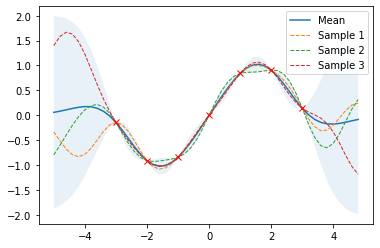

In [6]:
# let's model some function and do noiseless predictions on the same X as before

f = np.sin

# this could be written in a form of [[], [], []]
# but with reshape it's easier to modify
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
y_train = f(X_train).ravel()

# we use same X as before, and pass training data to calculate posterior
mu_s, cov_s = posterior(X, X_train, y_train)

# again, draw some samples from posterior distribution
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plot_gp(mu_s, cov_s, X, X_train, y_train, samples=samples)

That's the same, but now with noise.

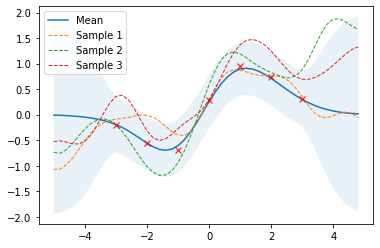

In [7]:
# now let's add some noise

noise = 0.3

# let's model some function and do noiseless predictions on the same X as before

f = np.sin

# this could be written in a form of [[], [], []]
# but with reshape it's easier to modify
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
y_train = f(X_train).ravel()
y_train = y_train + noise * np.random.randn(*y_train.shape)

# we use same X as before, and pass training data to calculate posterior
mu_s, cov_s = posterior(X, X_train, y_train, sigma_noise=noise)

# again, draw some samples from posterior distribution
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plot_gp(mu_s, cov_s, X, X_train, y_train, samples=samples)

Now let's explore different values of $\sigma$ and $l$ in the RBF kernel, as well as noise. We will use $\sigma=1, l=1, \epsilon=0.2$ by default, vary one at a time, and plot the GP to see how these hyperparameters affect it.

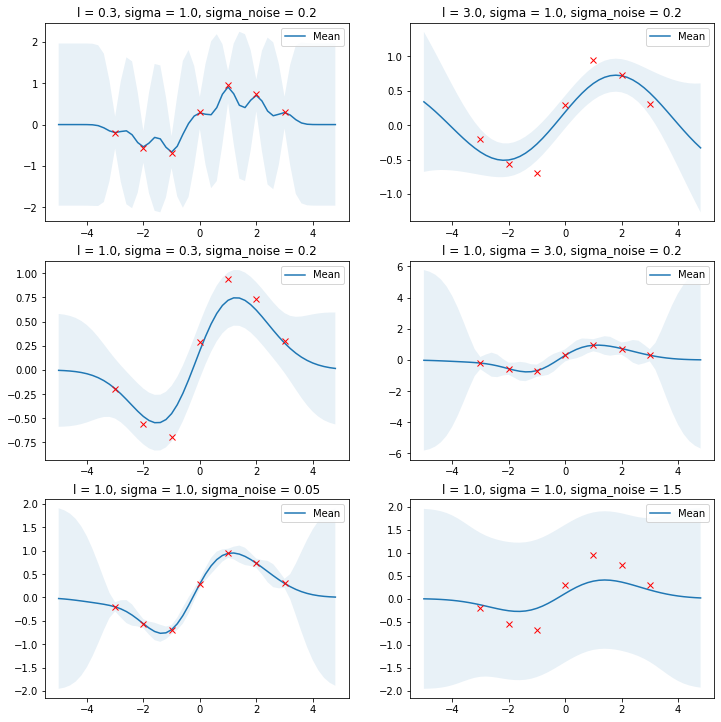

In [8]:
params = [
    # l, sigma, noise
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma, sigma_noise) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, y_train,
                            l=l, 
                            sigma=sigma, 
                            sigma_noise=sigma_noise)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma = {sigma}, sigma_noise = {sigma_noise}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=y_train)